# Setup Enviroment

In [ ]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

# Dependencies and Dataset

## Install Dependencies

In [1]:
!pip install -q numpy==1.26.4
!pip install -q tensorflow==2.18.0
!pip install opencv-python==4.11.0.86
!pip install -q scikit-image==0.25.2
!pip install -q matplotlib==3.7.2

## Download Dataset

In [2]:
import os

ds_path = "dataset/landscape-pictures"
os.makedirs(ds_path, exist_ok=True)

In [3]:
# Download and extract dataset
!curl -L https://www.kaggle.com/api/v1/datasets/download/arnaud58/landscape-pictures -o ./dataset/landscape-pictures.zip

import zipfile
with zipfile.ZipFile('dataset/landscape-pictures.zip', 'r') as zip_ref:
    zip_ref.extractall(ds_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  620M  100  620M    0     0   155M      0  0:00:03  0:00:03 --:--:--  166M


# Import Libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Concatenate,
    BatchNormalization, LayerNormalization, Dropout, MultiHeadAttention, Add, Reshape
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import cv2
import glob
import os
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pyplot as plt

2025-06-20 05:02:07.339274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750395727.529804      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750395727.587006      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Preparation


In [5]:
# Enable mixed precision training to reduce memory usage
set_global_policy('mixed_float16')

# Define constants
HEIGHT, WIDTH = 1024, 1024
BATCH_SIZE = 2

# Create directories for color and grayscale images
color_path = os.path.join(ds_path, 'color')
gray_path = os.path.join(ds_path, 'gray')
os.makedirs(color_path, exist_ok=True)
os.makedirs(gray_path, exist_ok=True)

# Organize and generate grayscale images
original_files = sorted(glob.glob(os.path.join(ds_path, '*.jpg')))
for f in original_files:
    color_file = os.path.join(color_path, os.path.basename(f))
    gray_file = os.path.join(gray_path, os.path.basename(f))
    if not os.path.exists(color_file):
        os.rename(f, color_file)
    if not os.path.exists(gray_file):
        img = cv2.imread(color_file)
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(gray_file, gray_img)

# Load file paths
color_files = sorted(glob.glob(os.path.join(color_path, '*.jpg')))
gray_files = sorted([os.path.join(gray_path, os.path.basename(f)) for f in color_files])
assert len(color_files) == len(gray_files), "File count mismatch"

# Image generator for L*a*b* color space
def image_generator(file_pairs):
    for gray_file, color_file in file_pairs:
        gray_img = cv2.imread(gray_file, cv2.IMREAD_GRAYSCALE)
        color_img = cv2.imread(color_file, cv2.IMREAD_COLOR)
        if gray_img is None or color_img is None:
            continue
        gray_img = cv2.resize(gray_img, (WIDTH, HEIGHT))
        color_img = cv2.resize(color_img, (WIDTH, HEIGHT))
        color_img = color_img[:, :, ::-1]  # BGR to RGB
        lab_img = rgb2lab(color_img / 255.0)
        L = lab_img[:, :, 0:1] / 100.0  # Normalize L*
        ab = lab_img[:, :, 1:] / 128.0  # Normalize a*b*
        yield L, ab

# Split dataset
file_pairs = list(zip(gray_files, color_files))
np.random.seed(42)
np.random.shuffle(file_pairs)
train_size = int(0.8 * len(file_pairs))
train_pairs, val_pairs = file_pairs[:train_size], file_pairs[train_size:]

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(train_pairs),
    output_signature=(
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 2), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(val_pairs),
    output_signature=(
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 2), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1750395782.941246      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Visualize some Samples

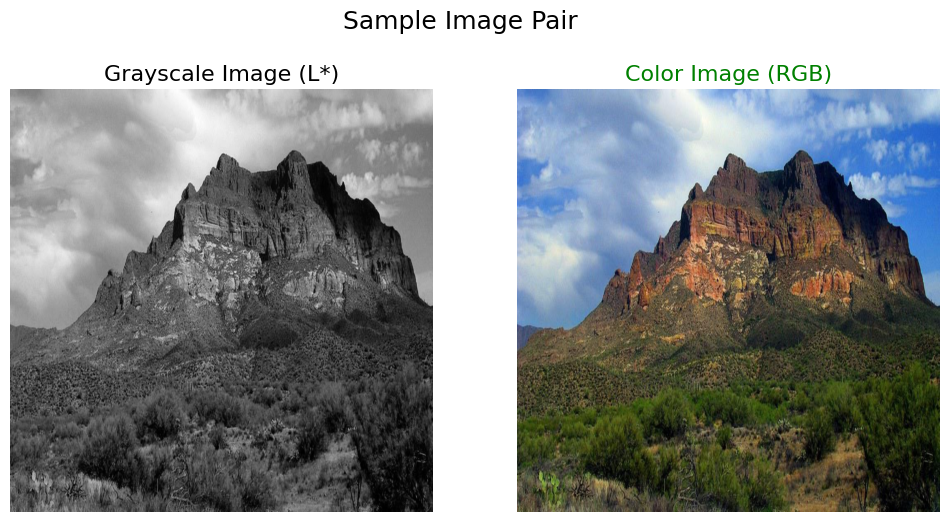

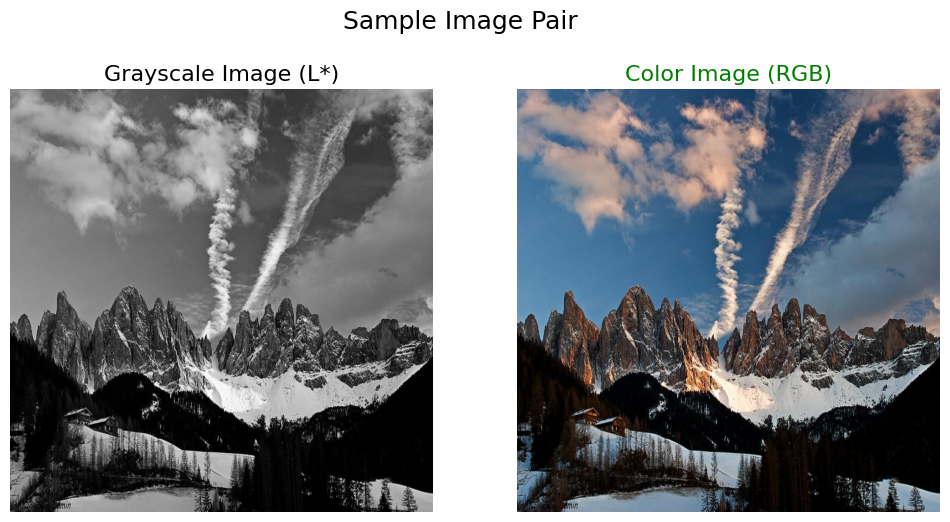

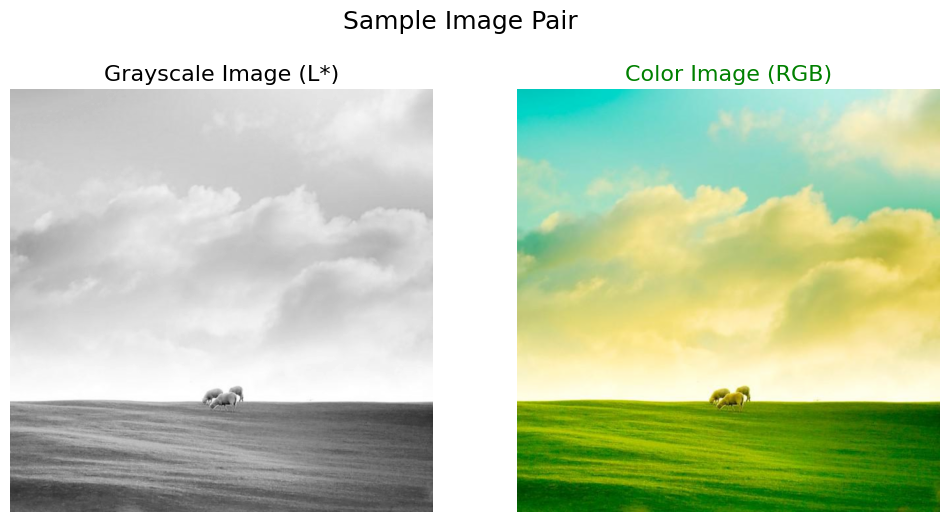

In [7]:
# Visualize sample image pairs
def plot_image_pair(L_img, ab_img, title='Image Pair'):
    L = L_img * 100.0
    ab = ab_img * 128.0
    lab = np.concatenate([L, ab], axis=-1)
    rgb = lab2rgb(lab)
    rgb = np.clip(rgb, 0, 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Grayscale Image (L*)', fontsize=16, color='black')
    plt.imshow(L[..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Color Image (RGB)', fontsize=16, color='green')
    plt.imshow(rgb)
    plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.show()

for L_img, ab_img in train_dataset.take(3):
    plot_image_pair(L_img[0].numpy(), ab_img[0].numpy(), 'Sample Image Pair')

# Modeling

## Model Architecture

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate, MultiHeadAttention, LayerNormalization, Layer
from tensorflow.keras.models import Model

# Custom self-attention layer with serialization support
@tf.keras.utils.register_keras_serializable()
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(SelfAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ln = LayerNormalization()

    def call(self, x):
        b, h, w, c = tf.shape(x)[0], x.shape[1], x.shape[2], x.shape[3]
        attention_input = tf.reshape(x, [b, h * w, c])
        attention_output = self.mha(attention_input, attention_input)
        attention_output = tf.reshape(attention_output, [b, h, w, c])
        return self.ln(x + attention_output)

    def get_config(self):
        config = super(SelfAttentionLayer, self).get_config()
        config.update({
            'num_heads': self.num_heads,
            'key_dim': self.key_dim
        })
        return config

def attention_unet_model(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder with reduced filters
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck with reduced filters and attention
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = SelfAttentionLayer(num_heads=2, key_dim=32)(c4)  # Reduced heads and key_dim

    # Attention gate
    def attention_gate(g, s, num_filters):
        g_conv = Conv2D(num_filters, (1, 1), padding='same')(g)
        s_conv = Conv2D(num_filters, (1, 1), padding='same')(s)
        attn = tf.keras.layers.add([g_conv, s_conv])
        attn = tf.keras.layers.Activation('relu')(attn)
        attn = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(attn)
        return s * attn

    # Decoder with reduced filters
    u5 = UpSampling2D((2, 2))(c4)
    a5 = attention_gate(u5, c3, 64)
    u5 = Concatenate()([u5, a5])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling2D((2, 2))(c5)
    a6 = attention_gate(u6, c2, 32)
    u6 = Concatenate()([u6, a6])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    a7 = attention_gate(u7, c1, 16)
    u7 = Concatenate()([u7, a7])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Output layer
    outputs = Conv2D(2, (1, 1), activation='tanh', padding='same')(c7)

    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
model = attention_unet_model(input_shape=(HEIGHT, WIDTH, 1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1024, 1024, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 1024, 1024, 1)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1024, 1024, 16) │            160 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024, 1024, 16) │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1024, 1024, 16) │          2,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1024, 1024, 16) │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 512, 512, 16)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512, 512, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 512, 512, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 256, 256, 32)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256, 256, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256, 256, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 539,653 (2.06 MB)

 Trainable params: 538,245 (2.05 MB)

 Non-trainable params: 1,408 (5.50 KB)

## CallBacks and Compile

In [9]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',       # Monitor validation loss
        patience=20,              # Stop after 10 epochs with no improvement
        restore_best_weights=True # Restore weights from the best epoch
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',       # Monitor validation loss
        factor=0.8,               # Reduce learning rate by half
        patience=5,               # Wait 5 epochs before reducing
        min_lr=1e-6               # Minimum learning rate
    ),
    tf.keras.callbacks.BackupAndRestore(
        backup_dir='./ckpts/unet/backup/',     # Directory to save backup checkpoints
        delete_checkpoint=False
    )
]

# Model compile
model.compile(optimizer=Adam(learning_rate=7e-5), 
                   loss=tf.keras.losses.MeanSquaredError())

## Model Training

In [10]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1750395808.608951     127 service.cc:148] XLA service 0x7dd17811a0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750395808.609870     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750395811.068657     127 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750395813.236877     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750395813.421370     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750395817.271783     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750395817.4768

   1727/Unknown 697s 369ms/step - loss: 0.0804

E0000 00:00:1750396489.145744     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750396489.323215     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750396491.534302     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750396491.713128     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750396492.387631     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

   1728/Unknown 722s 384ms/step - loss: 0.0804

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
E0000 00:00:1750396515.381120     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750396515.565852     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750396518.886683     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750396519.092281     127 gpu_timer.cc:82] Del

1728/1728 ━━━━━━━━━━━━━━━━━━━━ 882s 477ms/step - loss: 0.0804 - val_loss: 0.0155 - learning_rate: 7.0000e-05
Epoch 2/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 790s 457ms/step - loss: 0.0172 - val_loss: 0.0146 - learning_rate: 7.0000e-05
Epoch 3/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 782s 452ms/step - loss: 0.0158 - val_loss: 0.0136 - learning_rate: 7.0000e-05
Epoch 4/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 767s 444ms/step - loss: 0.0146 - val_loss: 0.0130 - learning_rate: 7.0000e-05
Epoch 6/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 765s 442ms/step - loss: 0.0143 - val_loss: 0.0129 - learning_rate: 7.0000e-05
Epoch 7/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 778s 450ms/step - loss: 0.0141 - val_loss: 0.0129 - learning_rate: 7.0000e-05
Epoch 8/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 801s 464ms/step - loss: 0.0138 - val_loss: 0.0126 - learning_rate: 7.0000e-05
Epoch 9/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 778s 450ms/step - loss: 0.0137 - val_loss: 0.0132 - learning_rate: 7.0000e-05
Epoch 10/100
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 

## Save the final model

In [ ]:
import os
# Create Model dir
model_dir = "./ckpts/unet"
model_path = os.path.join(model_dir, 'unet_colorization_model.keras')
os.makedirs(model_dir, exist_ok=True)
# Save model
model.save(model_path)

## Load the best model

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Load the model with custom objects to handle the SelfAttentionLayer
loaded_model = load_model(
    model_path,
    custom_objects={'SelfAttentionLayer': SelfAttentionLayer},
    compile=False
)

# Recompile the model with the same configuration as during training
loaded_model.compile(
    optimizer=Adam(learning_rate=7e-5),
    loss=MeanSquaredError()
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'self_attention_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


# Evaluation

## PSNR score

In [22]:
# Evaluation: PSNR score evaluation
def calculate_psnr(y_true, y_pred):
    y_true = (y_true * 128.0).numpy()  # Denormalize a*b*
    y_pred = (y_pred * 128.0)#.numpy()  # Denormalize a*b*
    return peak_signal_noise_ratio(y_true, y_pred, data_range=256)

psnr_scores = []
for L, ab_true in val_dataset:
    ab_pred = model.predict(L, verbose=0)
    for i in range(len(ab_true)):
        psnr = calculate_psnr(ab_true[i], ab_pred[i])
        psnr_scores.append(psnr)

mean_psnr = np.mean(psnr_scores)
print(f'Mean PSNR on validation set: {mean_psnr:.4f} dB')

Mean PSNR on validation set: 26.5499 dB


## Visualize some Predicted Samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


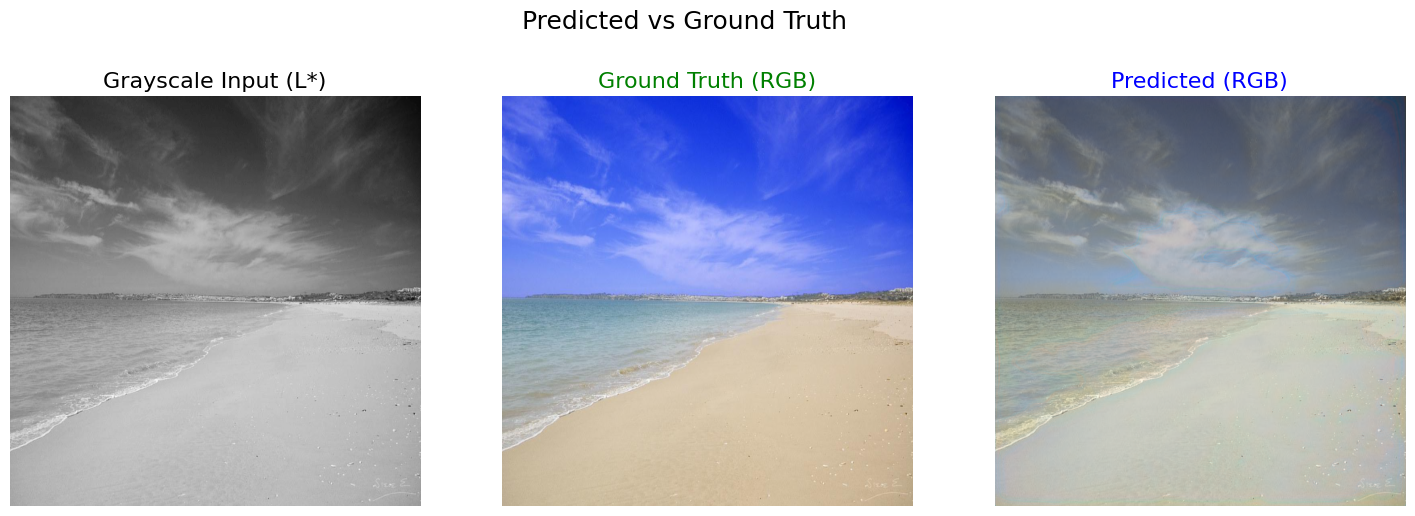

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


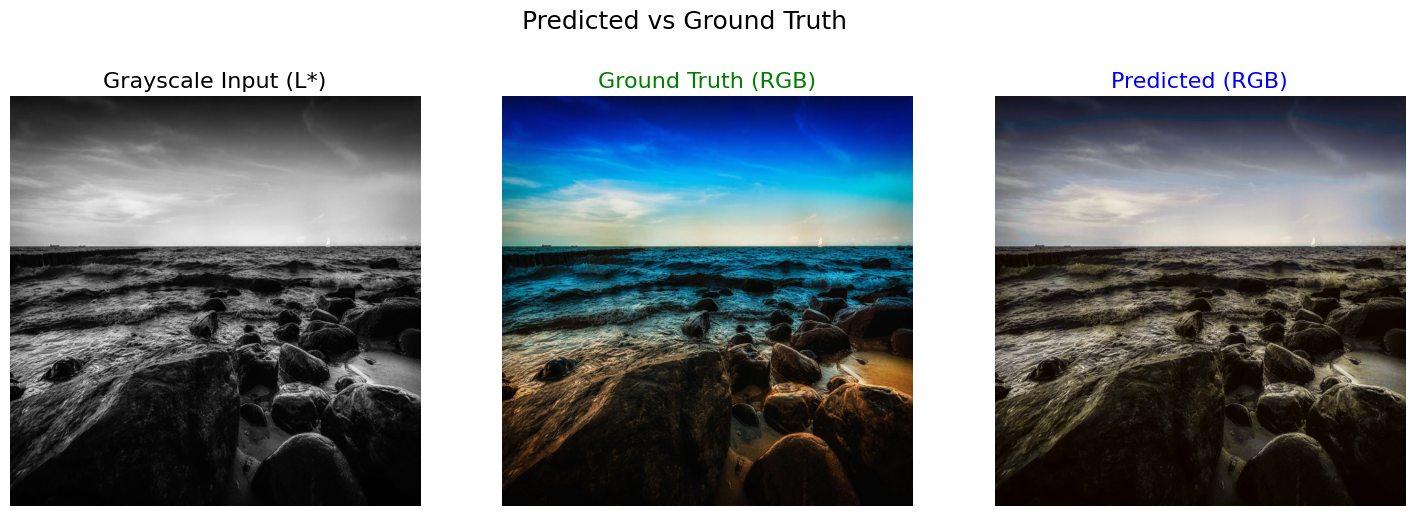

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


/tmp/ipykernel_35/2102976605.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 262 negative Z values that have been clipped to zero
  rgb_pred = lab2rgb(lab_pred)


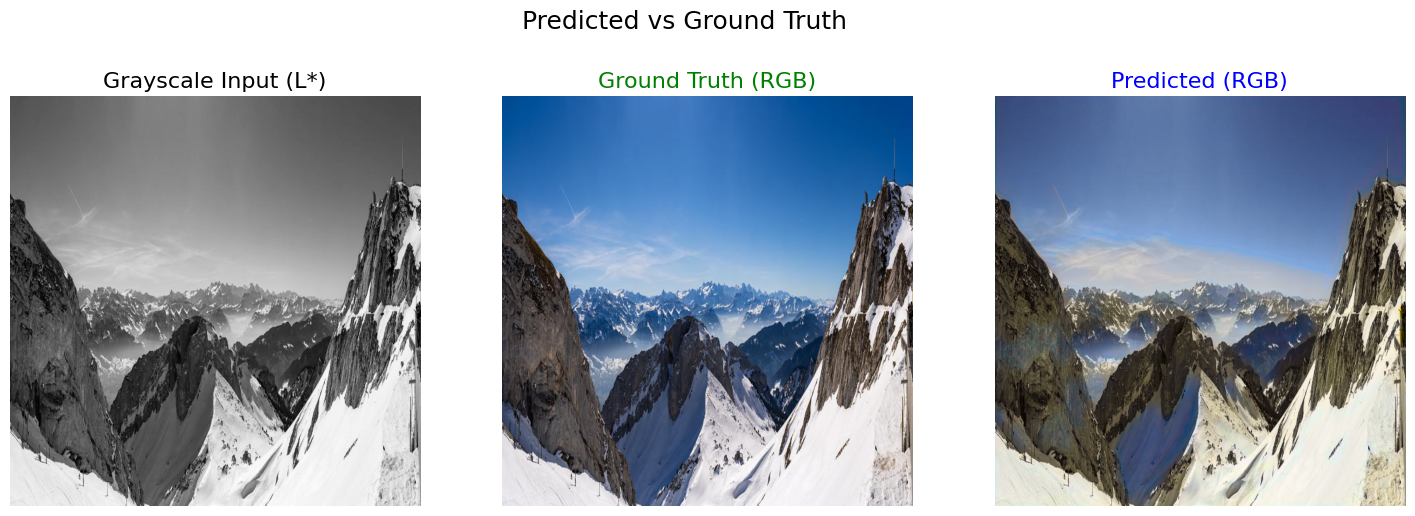

In [23]:
# Visualize some Predicted Samples
def plot_predicted_samples(L_img, ab_true, ab_pred, title='Predicted Image Pair'):
    L = L_img * 100.0  # Denormalize L*
    ab_true = ab_true * 128.0  # Denormalize true a*b*
    ab_pred = ab_pred * 128.0  # Denormalize predicted a*b*

    # Combine L* with true and predicted a*b*
    lab_true = np.concatenate([L, ab_true], axis=-1)
    lab_pred = np.concatenate([L, ab_pred], axis=-1)

    # Convert to RGB
    rgb_true = lab2rgb(lab_true)
    rgb_pred = lab2rgb(lab_pred)
    rgb_true = np.clip(rgb_true, 0, 1)
    rgb_pred = np.clip(rgb_pred, 0, 1)

    # Plot
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title('Grayscale Input (L*)', fontsize=16, color='black')
    plt.imshow(L[..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth (RGB)', fontsize=16, color='green')
    plt.imshow(rgb_true)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Predicted (RGB)', fontsize=16, color='blue')
    plt.imshow(rgb_pred)
    plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.show()

# Visualize predictions for 3 samples from validation set
for L_img, ab_true in val_dataset.take(3):
    ab_pred = model.predict(L_img)
    for i in range(min(1, len(L_img))):  # Show one image per batch
        plot_predicted_samples(L_img[i].numpy(), ab_true[i].numpy(), ab_pred[i], 'Predicted vs Ground Truth')